In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import itertools

from utilities2015 import *

from joblib import Parallel, delayed

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
section_id = 100

dm = DataManager(stack='MD593', section=section_id, segm_params_id='gridsize200')
dm._load_image(['gray'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


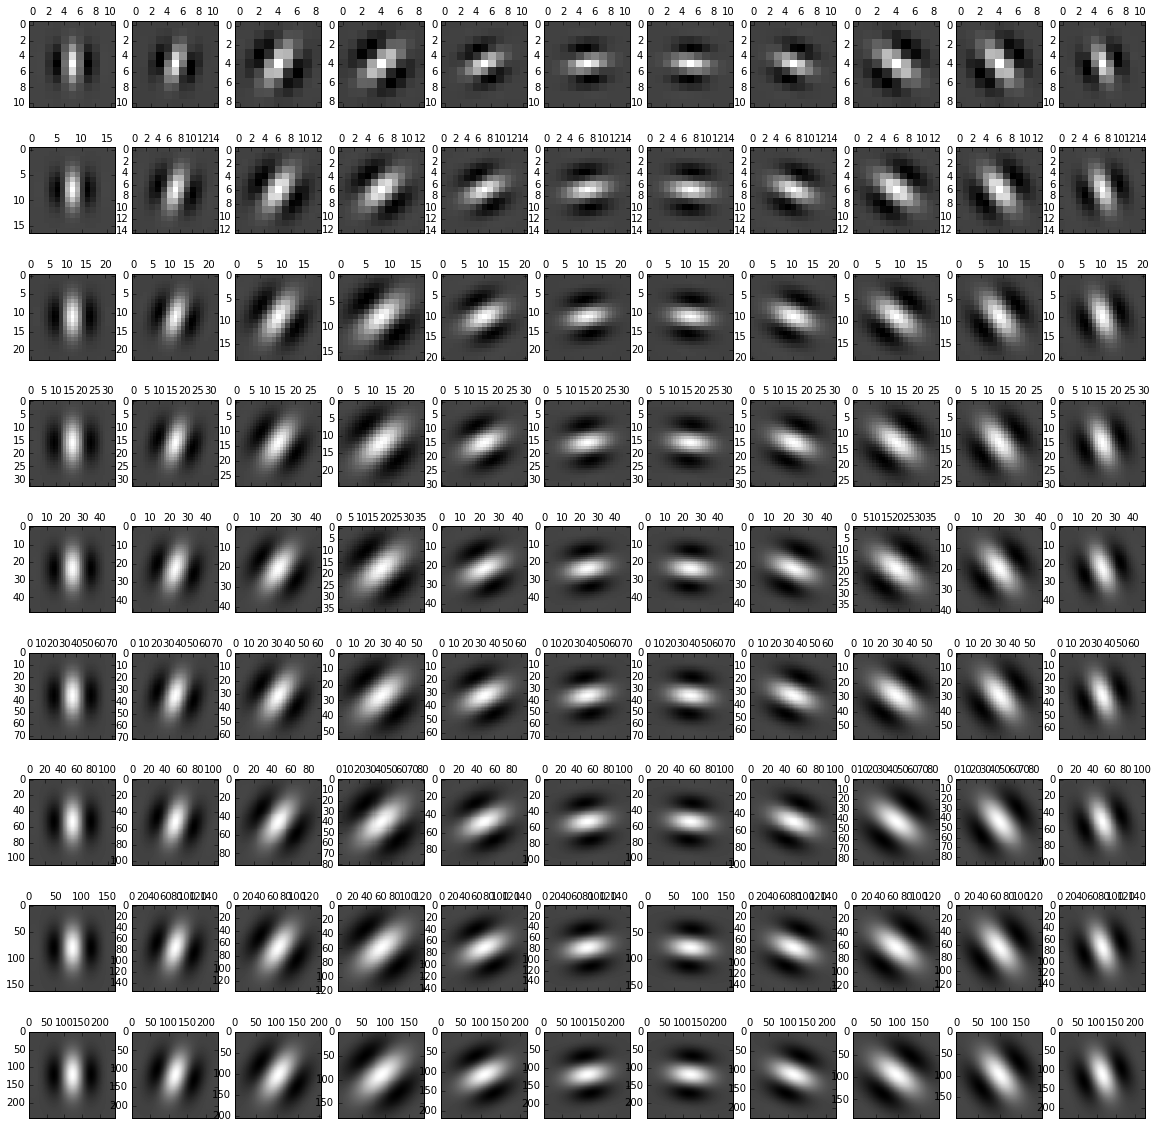

In [3]:
dm.visualize_kernels()

In [ ]:
mins = np.empty((n_kernel, ))
maxs = np.empty((n_kernel, ))
means = np.empty((n_kernel, ))
for i in range(n_kernel):
    a = cropped_features[:,:,i].astype(np.float32)
    mins[i] = a.min()
    maxs[i] = a.max()
    means[i] = a.mean()
    
# plt.bar(range(n_kernel), mins, color='r')
# plt.bar(range(n_kernel), maxs, color='b')
# plt.bar(range(n_kernel), means, color='g')

plt.errorbar(range(n_kernel), means, yerr=[abs(mins-means), maxs-means], fmt='--o')

In [5]:
# cropped_segmentation = dm.load_pipeline_result('cropSegmentation', 'npy')
# n_superpixels = len(unique(cropped_segmentation)) - 1

cropped_features = dm.load_pipeline_result('cropFeatures', 'npy').astype(np.float)
cropped_height, cropped_width = cropped_features.shape[:2]

cropped_mask = dm.load_pipeline_result('cropMask', 'npy')

cropped_features_tabular = np.reshape(cropped_features, (cropped_height, cropped_width, n_freq, n_angle))

loaded /home/yuncong/DavidData/RS141/x5/0001/filterResults/RS141_x5_0001_gabor-blueNisslWide_cropFeatures.npy
loaded /home/yuncong/DavidData/RS141/x5/0001/filterResults/RS141_x5_0001_gabor-blueNisslWide_cropMask.npy


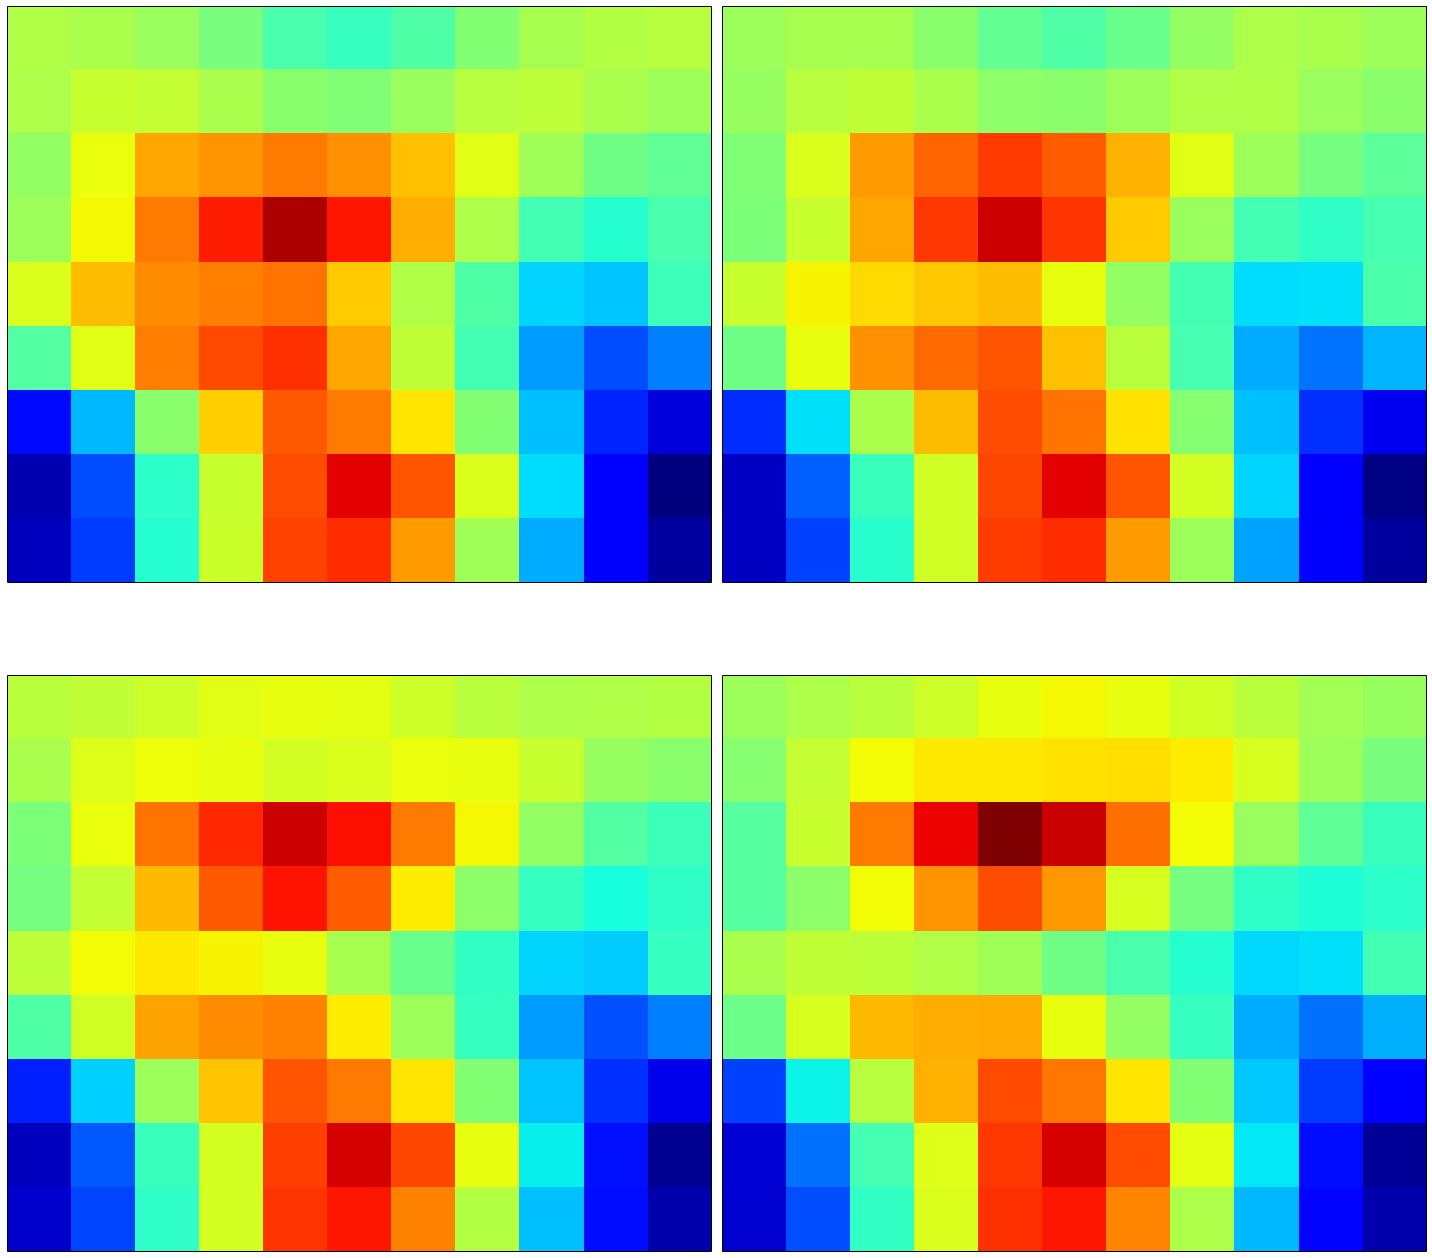

In [31]:
x0 = 4500
y0 = 2000
w = 20
h = 20

fig, axes = plt.subplots(h, w, figsize=(20,20), facecolor='white')

patch_min = cropped_features[y0:y0+h, x0:x0+w].min()
patch_max = cropped_features[y0:y0+h, x0:x0+w].max()

for i in range(h):
    for j in range(w):
        axes[i, j].matshow(cropped_features[i+y0, j+x0].reshape(n_freq, n_angle), vmin=patch_min, vmax=patch_max)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
plt.tight_layout()

# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# fig.colorbar(im, cax=cax)
# plt.savefig('patch_features.png', bbox_inches='tight')

plt.show()

In [9]:
max_freqs, max_angles = np.unravel_index(cropped_features.argmax(axis=2), (n_freq, n_angle))
max_responses = cropped_features.max(axis=2)
max_mean_ratio = max_responses/cropped_features.mean(axis=2)

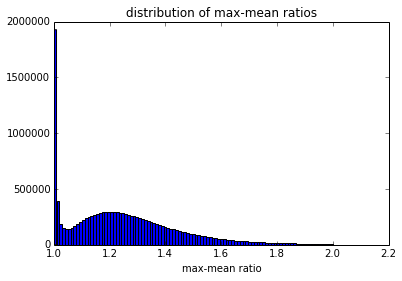

In [17]:
plt.hist(max_mean_ratio.flat, bins=np.linspace(1.,2.,100))
plt.xlabel('max-mean ratio')
plt.title('distribution of max-mean ratios')
plt.show()

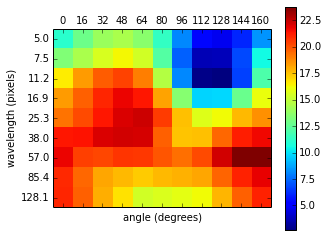

In [19]:
plt.matshow(cropped_features_tabular[497, 3651])

plt.xticks(range(n_angle))
xlabels = ['%d'%np.rad2deg(a) for a in angles]
plt.gca().set_xticklabels(xlabels)
plt.xlabel('angle (degrees)')
# 0 degree corresponds to vertical strips

plt.yticks(range(n_freq))
ylabels = ['%.1f'%a for a in 1./frequencies]
plt.gca().set_yticklabels(ylabels)
plt.ylabel('wavelength (pixels)')

plt.colorbar()

plt.show()

In [64]:
max_row, max_col = np.unravel_index(cropped_features_tabular[493, 3653].argmax(), (n_freq, n_angle))
print 'wavelength =', 1./frequencies[max_row], 'angle =', rad2deg(angles[max_col])

wavelength = 7.5 angle = 112.0


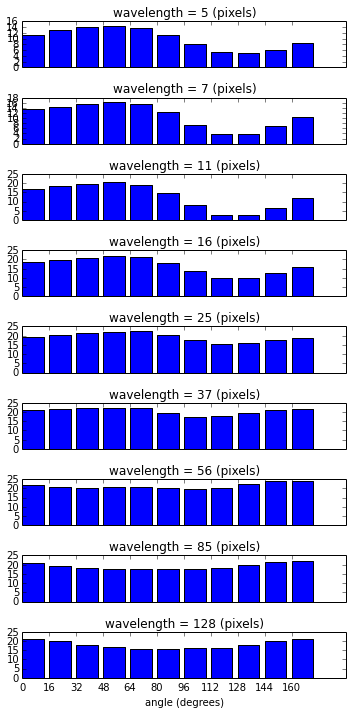

In [48]:
fig, axes = plt.subplots(n_freq, figsize=(5,10), sharex=True)
plt.xlabel('angle')

for i in range(n_freq):
    axes[i].bar(range(n_angle), cropped_features_tabular[497, 3651, i, :])
    axes[i].set_title('wavelength = %d (pixels)' % (1./frequencies[i]))
    
plt.xticks(range(n_angle))
xlabels = ['%d'%np.rad2deg(a) for a in angles]
plt.gca().set_xticklabels(xlabels)
plt.xlabel('angle (degrees)')
    
tight_layout()


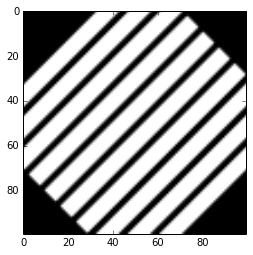

In [48]:
synthesized_strips = np.ones((100,100))
for i in range(0, 100, 10):
    synthesized_strips[i:i+3] = 0
    
from skimage.transform import rotate
    
synthesized_strips = rotate(synthesized_strips, 45)
    
plt.imshow(synthesized_strips, cmap=plt.cm.Greys_r)

In [49]:
from scipy.signal import fftconvolve

def convolve_per_proc(i):
    return fftconvolve(synthesized_strips, kernels[i], 'same').astype(np.half)

filtered = Parallel(n_jobs=16)(delayed(convolve_per_proc)(i) 
                        for i in range(n_kernel))

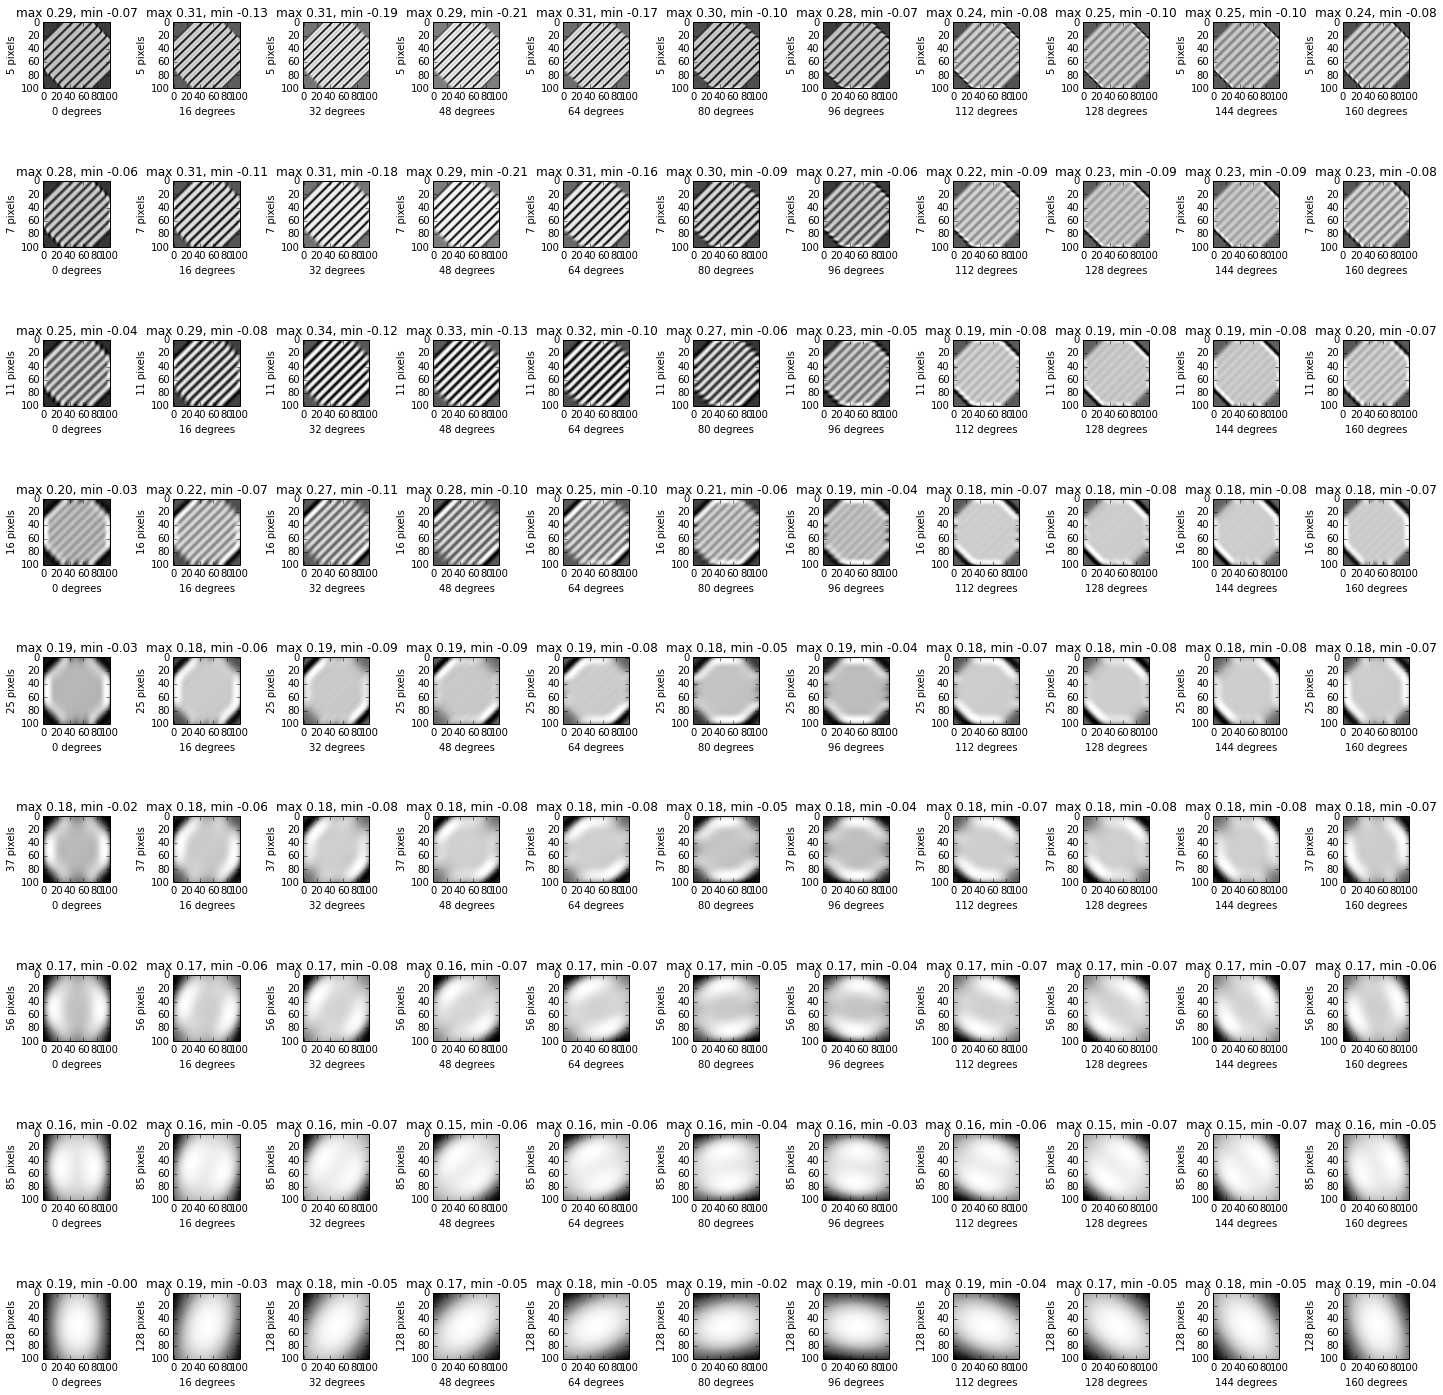

In [50]:
fig, axes = plt.subplots(n_freq, n_angle, figsize=(20,20))

for i in range(n_freq):
    for j in range(n_angle):
        axes[i,j].imshow(filtered[i*n_angle + j], cmap=plt.cm.Greys_r)
        axes[i,j].set_xlabel('%d degrees'%np.rad2deg(angles[j]))
        axes[i,j].set_ylabel('%d pixels'%(1./frequencies[i]))
        axes[i,j].set_title('max %.2f, min %.2f '%(filtered[i*n_angle + j].max(), filtered[i*n_angle + j].min()))
#         plt.title('kernel %d'%i)
tight_layout()

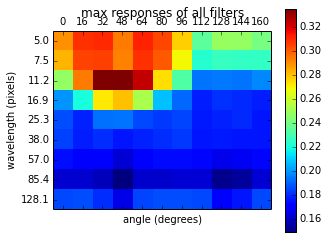

In [51]:
max_responses = np.reshape([f.max() for f in filtered], (n_freq, n_angle))

plt.matshow(max_responses)

plt.xticks(range(n_angle))
xlabels = ['%d'%np.rad2deg(a) for a in angles]
plt.gca().set_xticklabels(xlabels)
plt.xlabel('angle (degrees)')
# 0 degree corresponds to vertical strips

plt.yticks(range(n_freq))
ylabels = ['%.1f'%a for a in 1./frequencies]
plt.gca().set_yticklabels(ylabels)
plt.ylabel('wavelength (pixels)')

plt.title('max responses of all filters')

plt.colorbar()
plt.show()

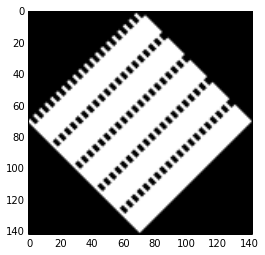

In [11]:
synthesized_rods = np.ones((100,100))
for i in range(0, 100, 20):
    synthesized_rods[i:i+5] = 0
for i in range(0, 100, 5):
    synthesized_rods[:, i:i+2] = 1
    
    
from skimage.transform import rotate
synthesized_rods = rotate(synthesized_rods, 45)
    
plt.imshow(synthesized_rods, cmap=plt.cm.Greys_r)

In [9]:
from scipy.signal import fftconvolve

def convolve_per_proc(i):
    return fftconvolve(synthesized_rods, kernels[i], 'same').astype(np.half)

filtered = Parallel(n_jobs=16)(delayed(convolve_per_proc)(i) 
                        for i in range(n_kernel))

In [ ]:
fig, axes = plt.subplots(n_freq, n_angle, figsize=(20,20))

for i in range(n_freq):
    for j in range(n_angle):
        axes[i,j].imshow(filtered[i*n_angle + j], cmap=plt.cm.Greys_r)
        axes[i,j].set_xlabel('%d degrees'%np.rad2deg(angles[j]))
        axes[i,j].set_ylabel('%d pixels'%(1./frequencies[i]))
        axes[i,j].set_title('max %.2f, min %.2f '%(filtered[i*n_angle + j].max(), filtered[i*n_angle + j].min()))
#         plt.title('kernel %d'%i)
tight_layout()

ERROR! Session/line number was not unique in database. History logging moved to new session 1176


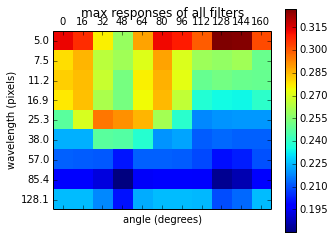

In [10]:
max_responses = np.reshape([f.max() for f in filtered], (n_freq, n_angle))

plt.matshow(max_responses)

plt.xticks(range(n_angle))
xlabels = ['%d'%np.rad2deg(a) for a in angles]
plt.gca().set_xticklabels(xlabels)
plt.xlabel('angle (degrees)')
# 0 degree corresponds to vertical strips

plt.yticks(range(n_freq))
ylabels = ['%.1f'%a for a in 1./frequencies]
plt.gca().set_yticklabels(ylabels)
plt.ylabel('wavelength (pixels)')

plt.title('max responses of all filters')

plt.colorbar()
plt.show()

In [ ]:
patch = dm.image[5488:5488+114, 2109:2109+132]

plt.imshow(patch, cmap=plt.cm.Greys_r)
plt.show()

patch2 = dm.image[5804:5804+196, 2001:2001+199]

plt.imshow(patch2, cmap=plt.cm.Greys_r)
plt.show()

# synthetic pattern 1
# pattern = np.ones((100,100))
# pattern[:,0:50:5] = 0
# pattern[:,50::10] = 0
# plt.imshow(pattern, cmap=plt.cm.Greys_r)

# synthetic pattern 2
# from skimage.transform import rotate
# w = 10
# h = 10
# im_stripes = np.zeros((h, w))
# stripe_spacing = 4
# stripe_width = 2
# for row in range(0, h, stripe_spacing):
#     im_stripes[row:row+stripe_width] = 1
# thetas = np.random.randint(0, 6, 8)*30
# ims = [rotate(im_stripes, -theta) > 0.5 for theta in thetas]
# pattern = np.vstack([np.hstack(ims[:3]), np.hstack([ims[3], np.zeros((h, w)), ims[4]]), np.hstack(ims[5:])])
# plt.imshow(pattern, cmap=plt.cm.Greys_r);

In [ ]:
features = dm.load_pipeline_result('features')

from skimage.util import pad
padded_kernels = [None] * dm.n_kernel
for i, kern in enumerate(dm.kernels):
    ksize = kern.shape[0]
    a = (dm.max_kern_size - ksize)/2
    padded_kern = pad(kern, [a, a], mode='constant', constant_values=0)
    padded_kernels[i] = padded_kern
    
for kern in padded_kernels:
    plt.matshow(kern, cmap=plt.cm.gray);
    plt.show();
    
F = np.vstack([k.flatten() for k in padded_kernels])
features_patch = features[:, 5496-dm.ymin, 8319-dm.xmin]
plt.bar(range(dm.n_kernel), features_patch);
plt.xlabel('kernel');


import itertools
f = np.column_stack([features_patch[:,i,j] for i,j in itertools.product(range(.shape[0]), range(pattern.shape[1]))])

from numpy.linalg import lstsq
b, r, _, _ = lstsq(F, features_patch.astype(np.float))

c = b.reshape((dm.max_kern_size,dm.max_kern_size))
print np.unravel_index(features_patch.argmax(), (dm.n_freq, dm.n_angle))
print 1./dm.frequencies[8], np.rad2deg(dm.angles[2])

plt.figure(figsize=(20,5))
plt.bar(range(dm.n_kernel), np.dot(F, b));
plt.xticks(np.arange(0, dm.n_kernel, dm.n_angle));
plt.xlabel('kernel');

plt.imshow(c, cmap=plt.cm.Greys_r)